# Marvel Network Centrality Scores

# Author: Oliver Gladfelter

# Date: October 17th, 2018

## Web scrape data on 4k Marvel characters for network analysis

In [1]:
import lxml.html as lh
import io
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt

# Get list of character from Earth-616

In [36]:
def getLinksFromCategory(url):
    
    links = []
    names = []
    lastLinkText = 'next 200'
    
    # every category page contains 200 character links, which we're collecting.
    # every page always has 'previous 200' and 'next 200' hyperlinked text, with links to
    # previous and next pages. We use these links to advance through the category pages. 
    # But when the 'next 200' text isn't hyperlinked, it won't be added to the list. This 
    # tells the loop we're on the last page and should stop
    while 'next' in lastLinkText:
        r = requests.get(url)

        if r.status_code != 200:
            continue 
        else:
            soup = BeautifulSoup(r.content, "lxml")

        # returns the last three unordered lists of the webpage
        unorderedLists = soup.find_all("ul",{'class':''})[1:]

        # for each unordered list (total of 3), grab the list of characters and save the wiki link to each one
        for unorderedList in unorderedLists:
            listOfCharacters = unorderedList.find_all('li')
            for character in listOfCharacters:
                if character.find('a') is None:
                    continue
                links.append('http://marvel.wikia.com' + character.find('a')['href'])
                names.append(character.text)
        
        # a list of links to the previous and next category pages
        previousNextLinks = soup.find_all('a',{'title':'Category:Earth-616 Characters'})
        # last one always be text attributed as 'next 200', unless we're on the last page
        lastLinkText = previousNextLinks[-1].text

        # create an url for the next page
        url = "http://marvel.wikia.com" + previousNextLinks[1]['href']
        
    return links, names

In [37]:
characters = "http://marvel.wikia.com/wiki/Category:Earth-616_Characters"

linksList, namesList = getLinksFromCategory(characters)

data = pd.DataFrame({'url':linksList,'nameAndUniverse':namesList})
data = data[2:]
data = data.reset_index()
del data['index']

data.head(2)

,url,nameAndUniverse
0,http://marvel.wikia.com/wiki/%27Spinner_(Earth...,'Spinner (Earth-616)
1,http://marvel.wikia.com/wiki/01100010_01110010...,01100010 01110010 01110101 01110100 01100101 (...


In [38]:
data.to_csv("C:\\Users\\glol7001\\Documents\\allMarvel616Characters.csv")

In [39]:
len(data)

26461

# Remove any characters not from Earth-616

In [40]:
def Earth616Boolean(value):
    if '(Earth-616)' in value:
        return 1
    else:
        return 0

data['Earth-616'] = data['nameAndUniverse'].apply(Earth616Boolean)
data = data[data['Earth-616'] == 1]
data = data.reset_index()
del data['index']
del data['Earth-616']

In [41]:
len(data)

26287

# Get number of comic book appearances for each character, remove those with less than 10

In [84]:
def getAppearanceCount(link):

    r = requests.get(link)

    if r.status_code != 200:
        return -1
    else:
        soup = BeautifulSoup(r.content, "lxml")

    uls = soup.findAll("ul")

    for ul in uls:
        if re.search("Appearances of",ul.text) is not None:
            appearanceItem = ul

    appearanceCount = appearanceItem.findAll("li")[0].text

    appearanceString = re.search("\s?([\d,]{,})\sA",appearanceCount).group(1)
    
    # catching an error
    if (appearanceString == 'First') | (appearanceString == ''):
        return -2
    
    # If a value has at least a thousand views, there is a comma in the
    # string which must be removed before converting to int
    return int(appearanceString.replace(",",""))

In [85]:
data['appearances'] = data['url'].apply(getAppearanceCount)

In [91]:
data2 = data[data['appearances'] > 9]
data2 = data2.reset_index()
del data2['index']

In [92]:
len(data2)

4031

In [93]:
data2.to_csv("C:\\Users\\glol7001\\Documents\\allMarvel616Characters2.csv")

# For each character, get list of comic books they've appeared in

In [94]:
def getAppearances(nameAndUniverse):
    
    # generate title to be used in link searching later
    title = 'Category:{}/Appearances'.format(nameAndUniverse)
    
    # use parameters generate url to search for appearances
    url = "http://marvel.wikia.com/wiki/Category:{}/Appearances?display=page&sort=mostvisited".format(nameAndUniverse.replace(" ","_"))

    comicBooks = []
    lastLinkText = 'next 200'
    
    # every category page contains 200 character links, which we're collecting.
    # every page always has 'previous 200' and 'next 200' hyperlinked text, with links to
    # previous and next pages. We use these links to advance through the category pages. 
    # But when the 'next 200' text isn't hyperlinked, it won't be added to the list. This 
    # tells the loop we're on the last page and should stop
    while 'next' in lastLinkText:
        r = requests.get(url)

        #if r.status_code != 200:
            #return -1 
        #else:
        soup = BeautifulSoup(r.content, "lxml")

        # returns the last three unordered lists of the webpage
        unorderedLists = soup.find_all("ul",{'class':''})

        # for each unordered list (total of 3), grab the list of characters and save the wiki link to each one
        for unorderedList in unorderedLists:
            listOfComicBooks = unorderedList.find_all('li')
            for comicBook in listOfComicBooks:
                comicBooks.append(comicBook.text)
        
        # a list of links to the previous and next category pages
        previousNextLinks = soup.find_all('a',{'title':title})
        
        try: # only necessary if character has 201+ appearances
            # last one always be text attributed as 'next 200', unless we're on the last page
            lastLinkText = previousNextLinks[-1].text

            # create an url for the next page
            url = "http://marvel.wikia.com" + previousNextLinks[1]['href']
        except:
            return comicBooks
     
    # list of every comic book they've appeared in
    return comicBooks

In [ ]:
data2['appearanceList'] = data2['nameAndUniverse'].apply(getAppearances)

In [97]:
len(data2)

4031

In [104]:
data2.to_csv("C:\\Users\\glol7001\\Documents\\MarvelAppearances.csv")
#data2 = pd.read_csv("C:\\Users\\glol7001\\Documents\\MarvelAppearances.csv")
#del data2['Unnamed: 0']
#import ast
#data2['appearanceList'] = data2['appearanceList'].apply(ast.literal_eval)

# Use List Intersections to Get Number of Common Comic Book Appearances, Construct a New DataFrame

In [ ]:
name1 = []
name2 = []
numConnections = []

for num in range(0,len(data2)):
    print(num)
    # only find intersection for all characters we haven't *already* 
    for num2 in range(num,len(data2)):
        if data2['nameAndUniverse'][num] == data2['nameAndUniverse'][num2]:
            continue
        name1.append(data2['nameAndUniverse'][num])
        name2.append(data2['nameAndUniverse'][num2])
        numConnections.append(len(set(data2['appearanceList'][num]).intersection(data2['appearanceList'][num2])))

network = pd.DataFrame({'name1':name1,'name2':name2,'numConnections':numConnections})

In [116]:
len(network)

8122465

In [68]:
network2 = network[network['numConnections'] != 0]
network2 = network2.reset_index()
del network2['index']

In [167]:
len(network2)

873005

In [170]:
network2.sort_values('numConnections',ascending=False).head()

,name1,name2,numConnections
152895,Benjamin Grimm (Earth-616),Jonathan Storm (Earth-616),1748
153668,Benjamin Grimm (Earth-616),Reed Richards (Earth-616),1743
822582,Reed Richards (Earth-616),Susan Storm (Earth-616),1663
627146,Jonathan Storm (Earth-616),Reed Richards (Earth-616),1653
153946,Benjamin Grimm (Earth-616),Susan Storm (Earth-616),1596


In [148]:
network2.to_csv("C:\\Users\\glol7001\\Documents\\MarvelNumConnections.csv")

# Creating Network and Calculating Centrality Scores

In [166]:
# Creating an empty graph object
networkGraph = nx.Graph()

# Iterating through the DataFrame to add edges
for _, edge in network2.iterrows():
    networkGraph.add_edge(edge['name1'], edge['name2'], weight=edge['numConnections'])
    
deg_cen = nx.degree_centrality(networkGraph)
sorted_deg_cen = sorted(deg_cen.items(), key=lambda x:x[1], reverse=True)

nameList = []
centralityScoreList = []

for character in sorted_deg_cen:
    nameList.append(character[0])
    centralityScoreList.append(character[1])
    
centralityScores = pd.DataFrame({'nameAndUniverse':nameList,'centralityScore':centralityScoreList})

centralityScores.head()

,nameAndUniverse,centralityScore
0,Steven Rogers (Earth-616),0.772840
1,Peter Parker (Earth-616),0.740318
2,Anthony Stark (Earth-616),0.727905
3,James Howlett (Earth-616),0.696375
4,Thor Odinson (Earth-616),0.662860


# Merging Centrality Scores with Character Data

In [165]:
centralityScores2 = centralityScores.merge(data2,how="left")

centralityScores2.head()

,nameAndUniverse,centralityScore,url,appearances,appearanceList
0,Steven Rogers (Earth-616),0.772840,http://marvel.wikia.com/wiki/Steven_Rogers_(Ea...,3604,"[All This and World War II, The Amazing Spider..."
1,Peter Parker (Earth-616),0.740318,http://marvel.wikia.com/wiki/Peter_Parker_(Ear...,4656,"[After Midnight, Amazing Spider-Man: The Big T..."
2,Anthony Stark (Earth-616),0.727905,http://marvel.wikia.com/wiki/Anthony_Stark_(Ea...,3304,"[Black Widow: Forever Red, Captain America and..."
3,James Howlett (Earth-616),0.696375,http://marvel.wikia.com/wiki/James_Howlett_(Ea...,3153,"[Legendary: A Marvel Deck Building Game, Marve..."
4,Thor Odinson (Earth-616),0.662860,http://marvel.wikia.com/wiki/Thor_Odinson_(Ear...,2478,"[Legendary: A Marvel Deck Building Game, Machi..."


In [203]:
def getSuperheroName(link):
    """
    All character pages list the character's birth/legal name as its title
    For example, Captain America's main page is titled "Steven Rogers"
    This function collects each individual's superhero name
    """

    r=requests.get(link)
    if r.status_code != 200:
        return -1
    soup = BeautifulSoup(r.content, "lxml")
    
    return soup.find('h2',{'pi-item pi-item-spacing pi-title'}).text

def rank(value):
    if (value == 0) | (value == 20):
        return "#" + str(1+value)
    return str(1+value)

centralityScores2['superName'] = centralityScores2['url'].apply(getSuperheroName)
centralityScores2['rank'] = centralityScores2['index'].apply(rank)

In [164]:
centralityScores2.to_csv("C:\\Users\\glol7001\\Documents\\finalMarvelNetworkData.csv")

# Preparing for Data Visualization

In [191]:
top20Appear = centralityScores2.sort_values('appearances',ascending=False).head(20)

top20Centrality = centralityScores2[0:20]
top20Centrality['superName'] = top20Centrality['url'].apply(getSuperheroName)
top20Centrality['superName'][15] = 'Nick Fury'

next20Centrality = centralityScores2[20:40]
next20Centrality['superName'] = next20Centrality['url'].apply(getSuperheroName)
next20Centrality = next20Centrality.reset_index()
del next20Centrality['index']
del next20Centrality['level_0']
next20Centrality = next20Centrality.reset_index()

top100 = centralityScores2[0:100]
top100['seen'] = ''

for num in range(0,len(top100)):
    if (top100['index'][num] == 9) | (top100['index'][num] == 21) | (top100['index'][num] == 28) | (top100['index'][num] == 40) | (top100['index'][num] == 44) | (top100['index'][num] == 48) | (top100['index'][num] == 49): 
        top100['seen'][num] = 0
    if (top100['index'][num] == 57) | (top100['index'][num] == 58) | (top100['index'][num] == 60) | (top100['index'][num] == 61) | (top100['index'][num] == 65) | (top100['index'][num] == 66)| (top100['index'][num] == 67) | (top100['index'][num] == 68) | (top100['index'][num] == 69) | (top100['index'][num] == 71) | (top100['index'][num] == 78) | (top100['index'][num] == 81) | (top100['index'][num] == 84):
        top100['seen'][num] = 0
        
top100cut = top100[top100['seen'] == 0]
del top100cut['index']
top100cut = top100cut.reset_index()
del top100cut['index']
top100cut = top100cut.reset_index()

top100cut['superName'][11] = 'Dazzler'

# Data Visualization

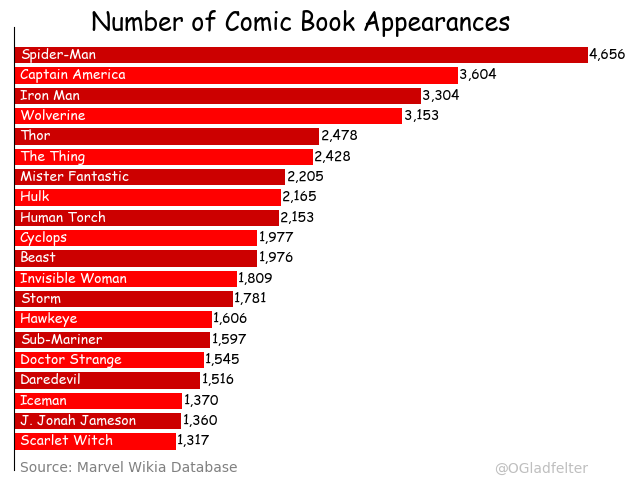

In [440]:
plt.rcdefaults()
fig, ax = plt.subplots()

colors = ["#cc0000","red"]

ax.barh(top20Appear['index'], top20Appear['appearances'], align='center',
        color=colors)
ax.set_yticks([])
ax.yaxis.set_ticks_position('none') 
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xticklabels([])

for character in range(0,len(top20Appear)):
    plt.text(top20Appear['appearances'][character] + 10,top20Appear['index'][character],str(top20Appear['appearances'][character])[0]+","+str(top20Appear['appearances'][character])[1:], verticalalignment ='center', horizontalalignment = 'left', color='black',fontname="Comic Sans MS")
    plt.text(50,top20Appear['index'][character],top20Appear['superName'][character],verticalalignment ='center', horizontalalignment = 'left', color='white',fontname="Comic Sans MS")
    
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.text(top20Appear['appearances'].max()/2,-1.25,"Number of Comic Book Appearances",fontsize=18,horizontalalignment='center',fontname="Comic Sans MS")

ax.xaxis.set_ticks_position('none') 
plt.tight_layout()

plt.text(4656,20.5,"@OGladfelter",color='gray',alpha=.5,horizontalalignment='right')
plt.text(50,20.5,"Source: Marvel Wikia Database",color='gray')

plt.savefig("C:\\Users\\glol7001\\Pictures\\MarvelAppearances.png", transparent = False)
plt.show()

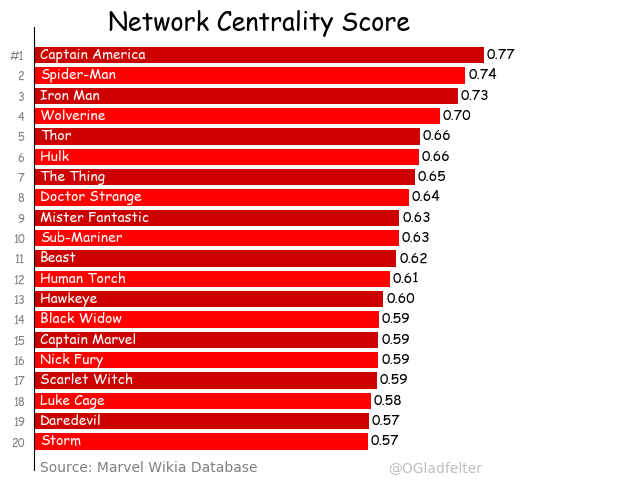

In [505]:
plt.rcdefaults()
fig, ax = plt.subplots()

colors = ["#cc0000","red"]

ax.barh(top20Centrality['index'], top20Centrality['centralityScore'], align='center',
        color=colors)
ax.set_yticks(top20Centrality['index'])
ax.set_yticklabels(top20Centrality['rank'], fontname = "Comic Sans MS",fontsize=8,color='gray')
ax.yaxis.set_ticks_position('none') 
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xticklabels([])

for character in range(0,len(top20Appear)):
    plt.text(top20Centrality['centralityScore'][character] + .005,top20Centrality['index'][character],str('{:.2f}'.format(top20Centrality['centralityScore'][character])), verticalalignment ='center', horizontalalignment = 'left', color='black',fontname="Comic Sans MS")
    plt.text(0.01,top20Centrality['index'][character],top20Centrality['superName'][character],verticalalignment ='center', horizontalalignment = 'left', color='white',fontname="Comic Sans MS")
    
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.gca().spines['right'].set_visible(False)

plt.text(top20Centrality['centralityScore'].max()/2,-1.25,"Network Centrality Score",fontsize=18,horizontalalignment='center',fontname="Comic Sans MS")

plt.xlim(0,1)

ax.xaxis.set_ticks_position('none') 
plt.tight_layout()

plt.text(.77,20.5,"@OGladfelter",color='gray',alpha=.5,horizontalalignment='right')
plt.text(.01,20.5,"Source: Marvel Wikia Database",color='gray')

plt.savefig("C:\\Users\\glol7001\\Pictures\\Marvelcentrality.png", transparent = False)

plt.show()

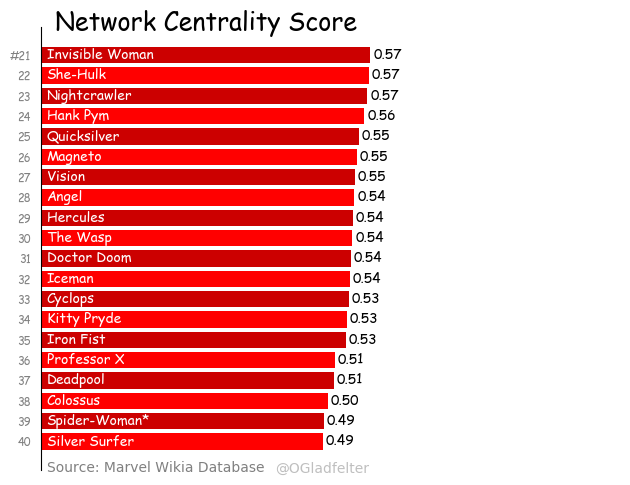

In [504]:
plt.rcdefaults()
fig, ax = plt.subplots()

colors = ["#cc0000","red"]

ax.barh(next20Centrality['index'], next20Centrality['centralityScore'], align='center',
        color=colors)
ax.set_yticks(next20Centrality['index'])
ax.set_yticklabels(next20Centrality['rank'], fontname = "Comic Sans MS",fontsize=8,color='gray')
ax.yaxis.set_ticks_position('none') 
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xticklabels([])

for character in range(0,len(top20Appear)):
    plt.text(next20Centrality['centralityScore'][character] + .005,next20Centrality['index'][character],str('{:.2f}'.format(next20Centrality['centralityScore'][character])), verticalalignment ='center', horizontalalignment = 'left', color='black',fontname="Comic Sans MS")
    plt.text(0.01,next20Centrality['index'][character],next20Centrality['superName'][character],verticalalignment ='center', horizontalalignment = 'left', color='white',fontname="Comic Sans MS")
    
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.gca().spines['right'].set_visible(False)

plt.text(next20Centrality['centralityScore'].max()/2,-1.25,"Network Centrality Score",fontsize=18,horizontalalignment='center',fontname="Comic Sans MS")

plt.xlim(0,1)

ax.xaxis.set_ticks_position('none') 
plt.tight_layout()

#plt.text(.82,19,"@OGladfelter",color='gray',alpha=.5,horizontalalignment='right',fontsize=8)
plt.text(.57,20.5,"@OGladfelter",color='gray',alpha=.5,horizontalalignment='right')
plt.text(.01,20.5,"Source: Marvel Wikia Database",color='gray')

plt.savefig("C:\\Users\\glol7001\\Pictures\\Marvelcentrality2.png", transparent = False)
    
plt.show()

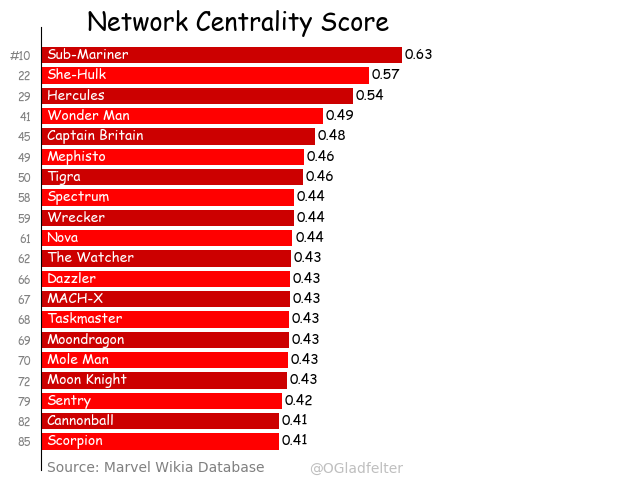

In [516]:
plt.rcdefaults()
fig, ax = plt.subplots()

colors = ["#cc0000","red"]

ax.barh(top100cut['index'], top100cut['centralityScore'], align='center',
        color=colors)
ax.set_yticks(top100cut['index'])
ax.set_yticklabels(top100cut['rank'], fontname = "Comic Sans MS",fontsize=8,color='gray')
ax.yaxis.set_ticks_position('none') 
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xticklabels([])

for character in range(0,len(top100cut)):
    plt.text(top100cut['centralityScore'][character] + .005,top100cut['index'][character],str('{:.2f}'.format(top100cut['centralityScore'][character])), verticalalignment ='center', horizontalalignment = 'left', color='black',fontname="Comic Sans MS")
    plt.text(0.01,top100cut['index'][character],top100cut['superName'][character],verticalalignment ='center', horizontalalignment = 'left', color='white',fontname="Comic Sans MS")
    
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.gca().spines['right'].set_visible(False)

plt.text(top100cut['centralityScore'].max()/2+.03,-1.25,"Network Centrality Score",fontsize=18,horizontalalignment='center',fontname="Comic Sans MS")

plt.xlim(0,1)

ax.xaxis.set_ticks_position('none') 
plt.tight_layout()

plt.text(.63,20.5,"@OGladfelter",color='gray',alpha=.5,horizontalalignment='right')
plt.text(.01,20.5,"Source: Marvel Wikia Database",color='gray')

plt.savefig("C:\\Users\\glol7001\\Pictures\\Marvelcentrality4.png", transparent = False)
    
plt.show()

# Visualizing Appearance and Centrality Together

## Normalizing Both Variables Onto a 0-1 Scale

In [534]:
def normalizeAppearances(value):
    return (value - centralityScores2['appearances'].min()) / (centralityScores2['appearances'].max() - centralityScores2['appearances'].min())

def normalizeCentrality(value):
    return (value - centralityScores2['centralityScore'].min()) / (centralityScores2['centralityScore'].max() - centralityScores2['centralityScore'].min())

top20Centrality['appearancesNormal'] = top20Centrality['appearances'].apply(normalizeAppearances)
top20Centrality['centralityNormal'] = top20Centrality['centralityScore'].apply(normalizeCentrality)

top100cut['appearancesNormal'] = top100cut['appearances'].apply(normalizeAppearances)
top100cut['centralityNormal'] = top100cut['centralityScore'].apply(normalizeCentrality)

# calculating difference between the normalized values for sorting purposes
top20Centrality['diff'] = abs(top20Centrality['appearancesNormal'] - top20Centrality['centralityNormal'])
top20Centrality = top20Centrality.sort_values('diff',ascending=False)
top20Centrality = top20Centrality.reset_index()
del top20Centrality['index']
del top20Centrality['level_0']
top20Centrality = top20Centrality.reset_index()

# calculating difference between the normalized values for sorting purposes
top100cut['diff'] = abs(top100cut['appearancesNormal'] - top100cut['centralityNormal'])
top100cut = top100cut.sort_values('diff',ascending=False)
top100cut = top100cut.reset_index()
del top100cut['index']
del top100cut['level_0']
top100cut = top100cut.reset_index()

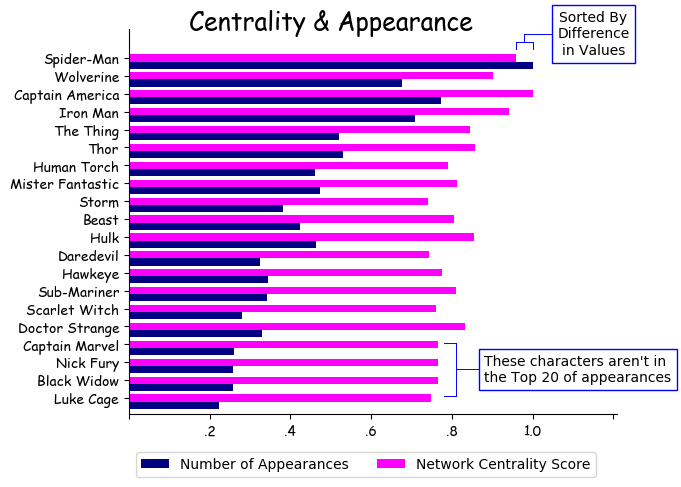

In [664]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

#df = pandas.DataFrame(dict(graph=['Item one', 'Item two', 'Item three'],
                           #n=[3, 5, 2], m=[6, 1, 3])) 

ind = np.arange(len(top20Centrality))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, top20Centrality.appearancesNormal, width, color='navy', label='Number of Appearances')
ax.barh(ind + width, top20Centrality.centralityNormal, width, color='magenta', label='Network Centrality Score')

ax.set(yticks=ind + width, yticklabels=top20Centrality.superName, ylim=[2*width - 1, len(top20Centrality)])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

ax.set_yticklabels(top20Centrality.superName,fontname = "Comic Sans MS")
ax.set_xticklabels(['','.2','.4','.6','.8','1.0'],fontname = "Comic Sans MS")

plt.plot([0.957905,1],[20.3,20.3],c='blue',linewidth=.7)
plt.plot([(1+.957905)/2,(1+.957905)/2],[20.3,20.75],c='blue',linewidth=.7)
plt.plot([(1+.957905)/2,1.15],[20.75,20.75],c='blue',linewidth=.7)
plt.plot([0.957905,0.957905],[19.9,20.3],c='blue',linewidth=.7)
plt.plot([1,1],[19.9,20.3],c='blue',linewidth=.7)
plt.text(1.15,20.75,"Sorted By\nDifference\nin Values",fontsize=10,horizontalalignment='center',fontname = "Sans Serif",verticalalignment='center',bbox=dict(edgecolor='blue',facecolor='white',alpha=1))

plt.plot([.81,.81],[.5,3.5],c='blue',linewidth=.7)
plt.plot([.78,.81],[3.5,3.5],c='blue',linewidth=.7)
plt.plot([.78,.81],[.5,.5],c='blue',linewidth=.7)
plt.plot([.81,.88],[2,2],c='blue',linewidth=.7)
plt.text(.88,2,"These characters aren't in\nthe Top 20 of appearances",fontsize=10,horizontalalignment='left',fontname = "Sans Serif",verticalalignment='center',bbox=dict(edgecolor='blue',facecolor='white',alpha=1))

plt.text(.5,21,"Centrality & Appearance",fontsize=18,horizontalalignment='center',fontname="Comic Sans MS")

ax.legend(bbox_to_anchor=(0,-.08), loc="upper left",fontsize=10, ncol = 2)

plt.ylim(-.5,21)

plt.tight_layout()
plt.savefig("C:\\Users\\glol7001\\Pictures\\MarvelCentralityAndAppearance.png", transparent = False)

plt.show()

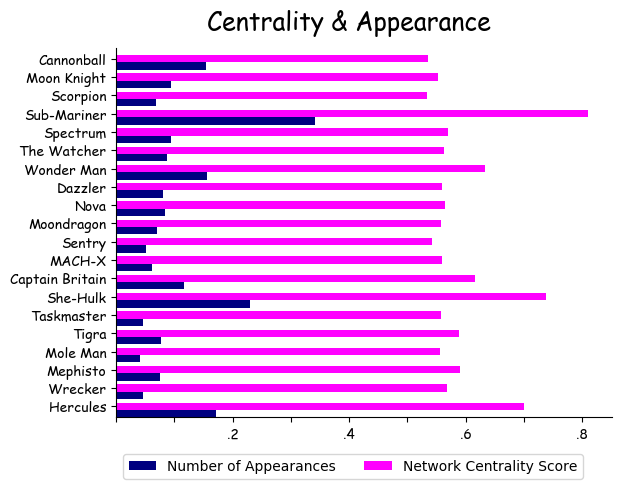

In [672]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

#df = pandas.DataFrame(dict(graph=['Item one', 'Item two', 'Item three'],
                           #n=[3, 5, 2], m=[6, 1, 3])) 

ind = np.arange(len(top100cut))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, top100cut.appearancesNormal, width, color='navy', label='Number of Appearances')
ax.barh(ind + width, top100cut.centralityNormal, width, color='magenta', label='Network Centrality Score')

ax.set(yticks=ind + width, yticklabels=top100cut.superName, ylim=[2*width - 1, len(top100cut)])
ax.legend(bbox_to_anchor=(0,-.08), loc="upper left",fontsize=10, ncol = 2)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

ax.set_yticklabels(top100cut.superName,fontname = "Comic Sans MS")
ax.set_xticklabels(['','','.2','','.4','','.6','','.8'],fontname = "Comic Sans MS")
plt.text(.4,21,"Centrality & Appearance",fontsize=18,horizontalalignment='center',fontname="Comic Sans MS")

plt.show()